In [35]:
import nengo
from nengo.utils.matplotlib import rasterplot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nengo_learn_assoc_mem.learning_rules.fake_voja import FakeVoja

In [36]:
class MeanMixed(FakeVoja):

    def __init__(self, encoders: np.ndarray, max_rates: np.ndarray, bias=1., max_dist=0.2,
                 post_tau=0.005, learning_rate=1e-3, radius=1., sample_every=0.1):
        super().__init__(encoders, post_tau, learning_rate, sample_every)
        self.radius = radius
        self.bias = bias
        self.max_dist = max_dist
        self.max_rates = max_rates

    def encode(self, t):
        firing_ratio = self.acts / self.max_rates
        assert np.all(firing_ratio <= 10.)

        threshold = self.bias * np.mean(firing_ratio)
        lr = self.enabled * self.learning_rate

        dist = self.encoders - self.in_sig
        dist_mag = np.linalg.norm(dist, axis=1)
        dist[dist_mag > self.max_dist] = 0.

        delta = lr * (firing_ratio[:, None] - threshold) * dist

        mod_enc = self.encoders + delta
        mag = np.linalg.norm(mod_enc, axis=1)
        self.encoders = self.radius / mag[:, None] * mod_enc

        if (t / self.dt % self.period) < 1:
            self.encoder_hist.append(self.encoders.copy())

        return np.dot(self.encoders, self.in_sig)

In [37]:
def cycle_array(x, period, dt=0.001):
    """Cycles through the elements"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        return x[int(i / i_every) % len(x)]

    return f

In [39]:
dims = 2
n_neurons = 50
seed = 8
rng = np.random.RandomState(seed)
intercepts = np.ones(n_neurons) * 0.8

rad_comp = 1 / np.sqrt(2)

In [40]:
x_val = np.linspace(0, 2*np.pi, n_neurons)
enc = np.array([np.cos(x_val), np.sin(x_val)]).T
max_rates = nengo.dists.Uniform(250, 300).sample(n_neurons, rng=rng)

In [41]:
neg_stim = np.array([-rad_comp, -rad_comp])

In [42]:
dist = enc - neg_stim
dist_mag = np.linalg.norm(dist, axis=1)
dist_mag[dist_mag > 0.5] = 0.

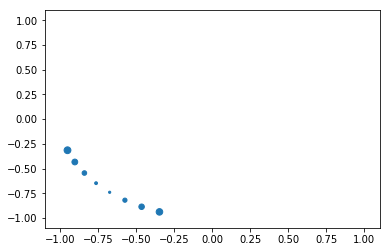

In [43]:
plt.scatter(enc[:, 0], enc[:, 1], label="orig", s=dist_mag*100)

In [67]:
with nengo.Network() as model:
    in_nd = nengo.Node(cycle_array([[-rad_comp, -rad_comp], [rad_comp, rad_comp]], 0.1))
    nvoja_learn_enable = nengo.Node(1)

    neg_voja = MeanMixed(enc.copy(), max_rates.copy(), bias=5.,
                         learning_rate=-1e-2, max_dist=0.5, sample_every=0.05)
    ens = nengo.Ensemble(n_neurons, 2, intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, neg_voja.input_signal, synapse=None)
    nengo.Connection(ens.neurons, neg_voja.input_activities, synapse=0)
    nengo.Connection(nvoja_learn_enable, neg_voja.enable, synapse=None)
    nengo.Connection(neg_voja.output, ens.neurons, synapse=None)


    p_in = nengo.Probe(in_nd)
    p_spikes = nengo.Probe(ens.neurons)

with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

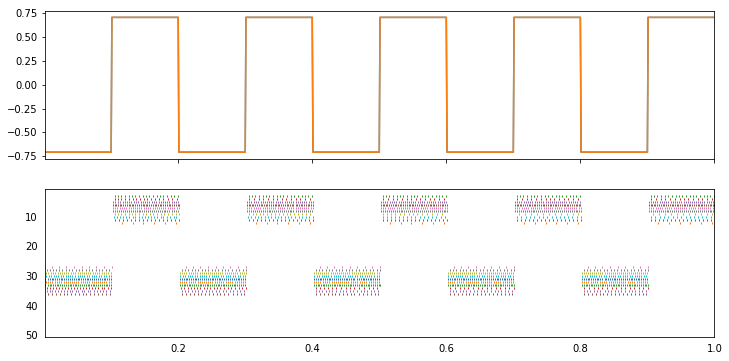

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(sim.trange(), sim.data[p_in])
rasterplot(sim.trange(), sim.data[p_spikes], ax=ax2)

In [69]:
x_val = np.linspace(0, 2*np.pi, 50)
circ = np.array([np.cos(x_val), np.sin(x_val)]).T

enc_h = neg_voja.encoder_hist

In [70]:
len(enc_h)

20

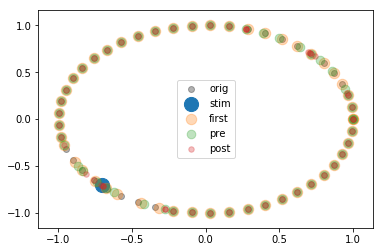

In [71]:
win_pre = 2
win_a = -1

alpha = 0.3

plt.scatter(enc[:, 0], enc[:, 1], color='k', alpha=alpha, label="orig")
plt.scatter(sim.data[p_in][win_pre][0], sim.data[p_in][win_pre][1], label="stim", s=200)

plt.scatter(enc_h[0][:, 0], enc_h[0][:, 1], label="first", s=110, alpha=alpha)
plt.scatter(enc_h[win_pre][:, 0], enc_h[win_pre][:, 1], label="pre", s=75, alpha=alpha)
plt.scatter(enc_h[win_a][:, 0], enc_h[win_a][:, 1], label="post", s=30, alpha=alpha)

plt.legend()
# plt.xlim(-1.1, 1.1)
# plt.ylim(-1.1, 1.1)